# The FFT and its application to signal denoising

_(Jupyter notebook by Simone Brugiapaglia)_

In this notebook we will study Fourier approximation and, in particular uses of the Fast Fourier Transform (FFT).

For more details, see Chapter 24 of 

*Q. Kong, T. Siauw, and A. M. Bayen. Python Programming and Numerical Methods: A Guide for Engineers and Scientists. Academic Press, 2021. (https://pythonnumericalmethods.berkeley.edu/)*

and Section 8.5 and 8.6 of

*Richard L. Burden, J. Douglas Faires and Annette M. Burden. Numerical Analysis (10th Edition). Cengage, 2016.*

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

## Why Fourier analysis?

One of the most important applications of Fourier analysis is signal processing (https://en.wikipedia.org/wiki/Signal_processing). Signal processing deals with the analysis, synthesis, and transormation of signals, such as audio recordings, images or video. To perform certain operations on signals, it is convenient to study them in the *frequency domain*, i.e. after applying a (discrete) Fourier transform. 

In this notebook, after introducing elementary sine waves, we will iullstrate how to *denoise* (i.e., remove noise from) a signal using the FFT.

## The elementary building blocks of Fourier analysis: sine waves

In the rest of this notebook, we will assume to work with one-dimensional signals (such as, e.g., audio signals or electrocardiograms). Hence, we will think about signals as functions of time, $f(t)$. *Sine waves* are elementary, purely oscillatory signals of the form 
$$
f(t) = A \sin(\omega t + \phi),
$$
characterized by an amplitude $A$, a frequency $\omega$ and a phase $\phi$. 

We can discretize a continuous signal by sampling it at a grid of equispaced time values
$$
x_j = f(t_j), \quad j = 0, \ldots, N-1,
$$
where $t_{j+1} - t_j = h >0$. 

Let's visualize some discretized sine waves.

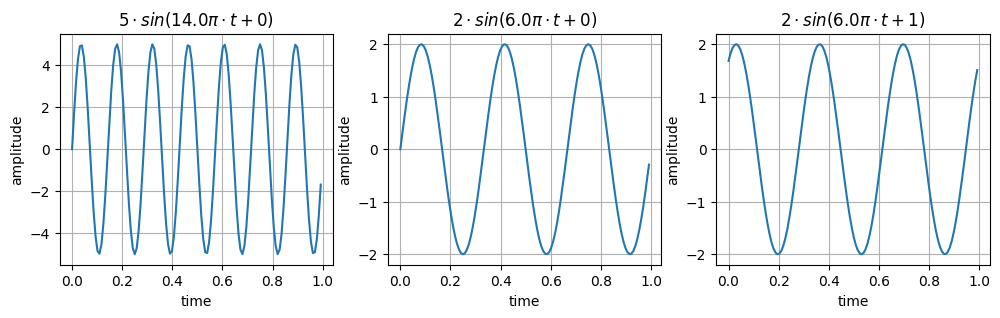

In [2]:
sine_wave = lambda ampli, freq, phase, t: ampli * np.sin(freq * t + phase) # define generic sine wave

h = 1/128 # time step size -- 1/h is called "sampling rate"
t_grid = np.arange(0,1,h) # grid of time values

# define valus for amplitude, frequency and phase
ampli_vals = np.array([5, 2, 2])
freq_vals = np.array([7, 3, 3])  * 2 * math.pi
phase_vals = np.array([0, 0, 1])

plt.figure(figsize = (12, 3) ) # set figure parameters

# create and visualize sine waves
for i in np.arange(len(ampli_vals)):
    ampli = ampli_vals[i]
    freq  = freq_vals[i]
    phase = phase_vals[i]

    # visualize current sine wave
    plt.subplot(1, 3, i+1)
    plt.plot(t_grid, sine_wave(ampli, freq, phase, t_grid))
    plt.title('$'+str(ampli)+'\cdot sin('+str(freq/math.pi)+'\pi \cdot t + '+str(phase)+')$')
    plt.grid()
    plt.xlabel('time')
    plt.ylabel('amplitude')

By considering superpositions of sine waves we can create complex signals, similar to those encountered in real-world scenarios. This is one of the key principles behind Fourier analysis.

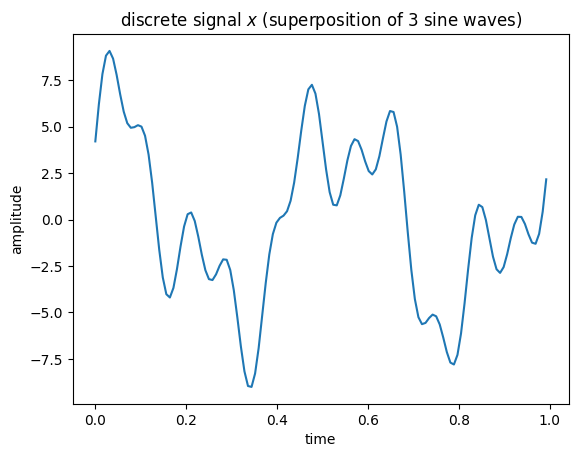

In [3]:
# Create 3 sine waves
wave_1 = sine_wave(5, 2 * 2 * math.pi, 1, t_grid)
wave_2 = sine_wave(3, 5 * 2 * math.pi, 0, t_grid)
wave_3 = sine_wave(2, 11 * 2 * math.pi, 0, t_grid)

# create signal as superposition of sine waves
signal = wave_1 + wave_2 + wave_3

# visualize signal
plt.plot(t_grid, signal)
plt.title('discrete signal $x$ (superposition of 3 sine waves)')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.show()

## Discrete and fast Fourier transforms 

The *Discrete Fourier Transform (DFT)* of a discrete signal $x$ is the $N$-dimensional vector $\texttt{DFT}(x)$ with entries 
$$
\texttt{DFT}(x)_k = \sum_{j = 0}^{N-1} x_j \exp\left(- \frac{i 2 \pi jk}{N} \right), \quad k= 0,\ldots N-1.
$$
The FFT algorithm exploits algebraic properties of the $N$th roots of unity, when $N = 2^p$, in order to compute the DFT vector fast, namely using  $O(N \log_2 N)$ arithmetic operations, for $N \to \infty$. This is remarkable, since using the standard definition, computing $\texttt{DFT}(x)$ would cost $O(N^2)$ operations instead (why?).

The *Inverse Discrete Fourier Transform (IDFT)* of a vector $y$ is defined as 
$$
\texttt{IDFT}(y)_k = \frac1N\sum_{j = 0}^{N-1} y_j \exp\left(\frac{i 2 \pi jk}{N} \right), \quad k= 0,\ldots N-1.
$$
Its fast implementation is called IFFT.


The FFT and IFFT are implemented in the `fft` and `ifft` built-in functions of the `numpy.fft` module. Let's compute the DFT of the previous signal $x$.

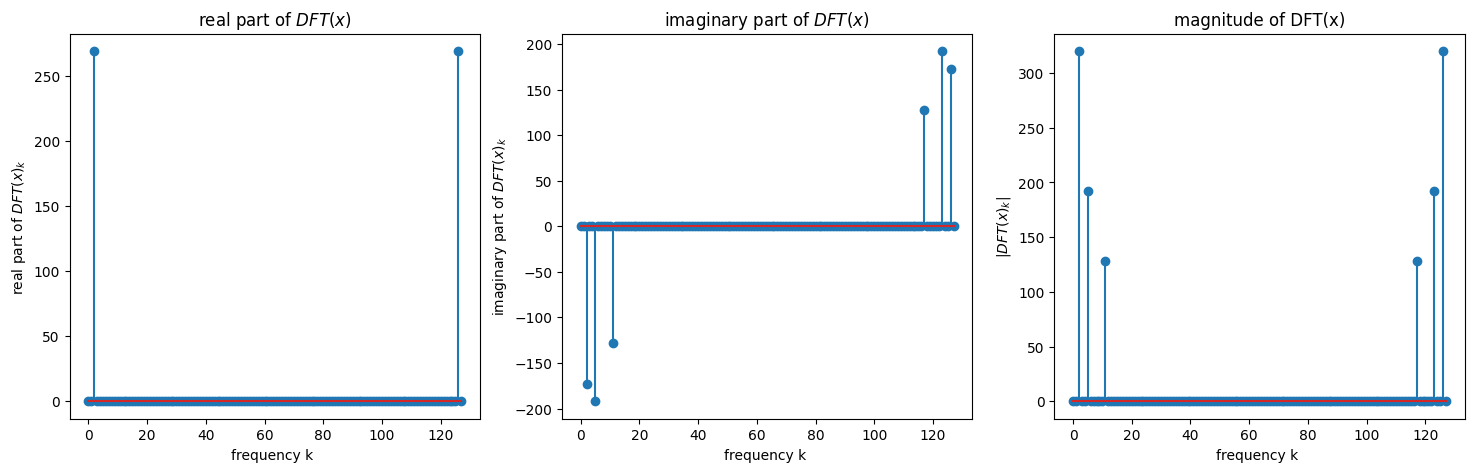

In [4]:
# import fft anf ifft functions
from numpy.fft import fft, ifft

signal_FFT = fft(signal) # compute FFT of the signal

freq_grid = np.arange(len(signal_FFT)) #


plt.figure(figsize = (18, 5) )

plt.subplot(131)
plt.stem(freq_grid, np.real(signal_FFT))
plt.xlabel('frequency k ')
plt.ylabel('real part of $DFT(x)_k$')
plt.title('real part of $DFT(x)$')

plt.subplot(132)
plt.stem(freq_grid, np.imag(signal_FFT))
plt.xlabel('frequency k ')
plt.ylabel('imaginary part of $DFT(x)_k$')
plt.title('imaginary part of $DFT(x)$')

plt.subplot(133)
plt.stem(freq_grid, np.abs(signal_FFT))
plt.xlabel('frequency k ')
plt.ylabel('$|DFT(x)_k|$')
plt.title('magnitude of DFT(x)')


plt.show()

Remarkably, the DFT of the signal contains only a few (numerically) nonzeros entries, in the following positions:

In [5]:
np.nonzero(abs(signal_FFT) > 1e-10 )

(array([  2,   5,  11, 117, 123, 126]),)

The first 3 frequencies multiplied by a factor $2\pi$ (this rescaling is due to the fact that we are working on the interval $[0,1]$ as opposed to the canonical $[0,2\pi]$) exactly correspond to the frequencies of the three sine waves composing the signal! Therefore, the DFT is able to identify what "frequency building blocks" the signal is made of. 

The remaining frequencies as of the form $N-k$ where $k$ are the first small frequencies (check this!). This symmetry is due to the fact that the signal is real valued. Try to show that $\texttt{DFT}_{n-k}(x)= \overline{\texttt{DFT}_{k}(x)}$ (Hint: you should use the properties of the $N$th complex root of unity and the fact that $\bar{x} = x$).

Now, let's run "sanity check", i.e. let's test the fact that $\texttt{IDFT}(\texttt{DFT}(x)) = x$ using the `fft` and the `ifft` commands.

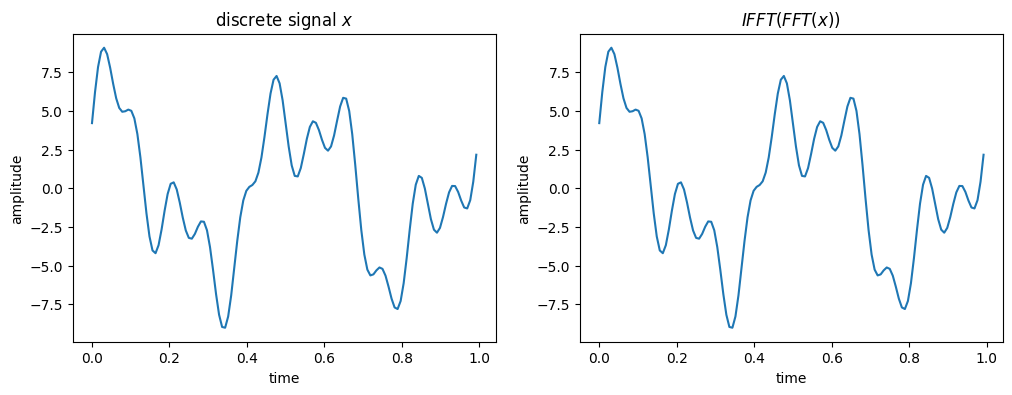

In [6]:

plt.figure(figsize = (12, 4) )

plt.subplot(121)
plt.plot(t_grid, signal)
plt.title('discrete signal $x$')
plt.xlabel('time')
plt.ylabel('amplitude')

plt.subplot(122)
plt.plot(t_grid, np.real(ifft(signal_FFT))) 
plt.title('$IFFT(FFT(x))$')
plt.xlabel('time')
plt.ylabel('amplitude')

plt.show()

## Application to signal denosing 

We conclude by illustrating a method to denoise a signal using the FFT and the IFFT. First, we generate a noisy signal by adding random white noise to the previously generated signal.

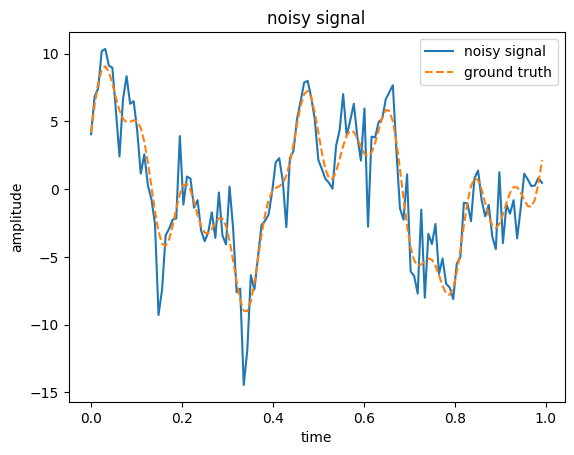

In [7]:
noise = 2 * np.random.randn(len(t_grid))  # random white noise (i.i.d. Gaussian)
noisy_signal = signal + noise

plt.plot(t_grid, noisy_signal, label = 'noisy signal')
plt.plot(t_grid, signal, '--',  label = 'ground truth')
plt.title('noisy signal')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.legend()
plt.show()

Now, the idea is to exploit the fact that white noise is evenly spread in the frequency spectrum (intuitively, this is due to the fact that white noise does not have any underlying structure in terms of elementary waves). Therefore, after computing the $\texttt{DFT}(x)$ where $x$ is the noisy signal, we "filter" it by setting to zero all the entries of $\texttt{DFT}(x)$ whose absolute value is below a certain threshold $T$. In other words, we define
$$
\texttt{filtered}(\texttt{DFT}(x))_k = 
\begin{cases}
\texttt{DFT}(x)_k & \text{if } |\texttt{DFT}(x)_k| \geq T\\
0 & \text{otherwise}\\
\end{cases}
$$
The choice of the threshold $T$ can be delicate and has to be calibrated based on the signal processing application of interest. 

The denoised or "clean" signal is obtained by applying the IDFT to the filtered DFT vector. Let's test this strategy on our noisy signal.

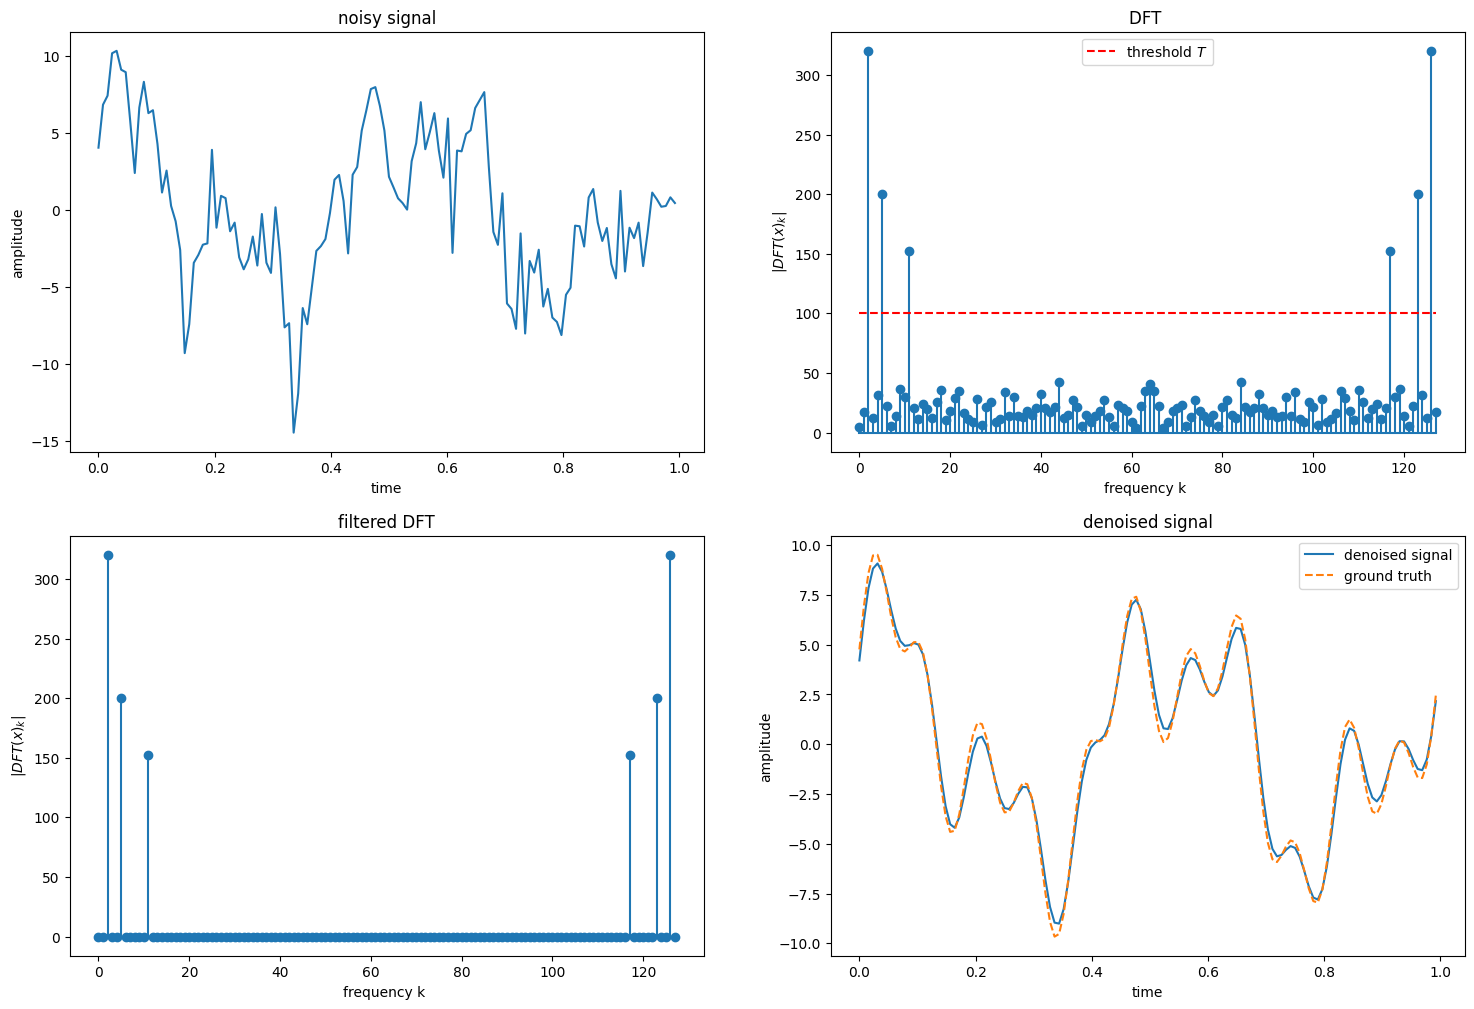

In [8]:
threshold = 100 # define the threshold

noisy_signal_FFT = fft(noisy_signal) # compute DFT of noisy signal

# compute filtered DFT
noisy_signal_FFT_filtered = noisy_signal_FFT.copy()
noisy_signal_FFT_filtered[abs(noisy_signal_FFT_filtered) < threshold] = 0

# compute cleaned signal
clean_signal = np.real(ifft(noisy_signal_FFT_filtered))


# visualize results
plt.figure(figsize = (18, 12) )

plt.subplot(221)
plt.plot(t_grid, noisy_signal)
plt.title('noisy signal')
plt.xlabel('time')
plt.ylabel('amplitude')

plt.subplot(222)
plt.stem(freq_grid, np.abs(noisy_signal_FFT), basefmt = '')
plt.plot(freq_grid, threshold * np.ones(len(freq_grid)), '--r', label = 'threshold $T$')
plt.legend()
plt.title('DFT ')
plt.xlabel('frequency k ')
plt.ylabel('$|DFT(x)_k|$')

plt.subplot(223)
plt.stem(freq_grid, np.abs(noisy_signal_FFT_filtered), basefmt = '')
plt.title('filtered DFT')
plt.xlabel('frequency k ')
plt.ylabel('$|DFT(x)_k|$')

plt.subplot(224)
plt.plot(t_grid, signal, label = 'denoised signal')
plt.plot(t_grid, clean_signal, '--', label = 'ground truth')
plt.title('denoised signal')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.legend()


plt.show()

The ground truth signal is recovered quite well!

## Recommended problems

1. Can you extract the noise from the noisy signal using the `fft` and `ifft` commands?
2. Play with different signals and with noise of various magnitudes. Can you "break" the DFT-based denoiser presented in this notebook?
3. Implement a function `DFT` that computes the DFT using its standard definition. Compare its speed with that of the built-in `fft` command using `timeit` (https://docs.python.org/3/library/timeit.html).

4. Read section 24.4.3 of 

   *Q. Kong, T. Siauw, and A. M. Bayen. Python Programming and Numerical Methods: A Guide for Engineers and Scientists. Academic Press, 2021. (https://pythonnumericalmethods.berkeley.edu/)*

   and run the real-world example.